Hypothesis: the model optimizations (force-consider; graph-normalization; and both) do not affect the payoff of the optimal policy

Fact: The policy itself is affected as state and action spaces are not the same after applying the optimizations.

Plan: Take the models with fixed exploration depth, solve MDPs compare results.

Note: In principle we should check this for various gammas and alphas.

In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("4-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol,depth,size,time_spent,rss,mdp
0,reference,fc16sapirshtein,True,True,True,True,bitcoin,2,14,0.087292,0.108395,27952cf1
1,baseline,generic_1,False,False,True,True,bitcoin,2,169,0.114033,0.135948,69dce8c8
2,baseline,generic_1,False,False,True,True,ethereum_3,2,291,0.556252,0.146263,4d20e46e
3,baseline,generic_1,False,False,True,True,byzantium_3,2,291,0.584332,0.149483,9add7283
4,baseline,generic_1,False,False,True,True,ghostdag_3,2,303,0.608089,0.151218,1464cb49
5,baseline,generic_1,False,False,True,True,parallel_3,2,2309,1.472804,0.164925,67685f04
6,w/ force consider,generic_1,True,False,True,True,bitcoin,2,83,0.466182,0.161274,4a2aeffd
7,w/ force consider,generic_1,True,False,True,True,ethereum_3,2,267,0.662471,0.166985,18b81fcb
8,w/ force consider,generic_1,True,False,True,True,byzantium_3,2,267,0.696327,0.169182,1d8e5bac
9,w/ force consider,generic_1,True,False,True,True,ghostdag_3,2,111,0.597705,0.171299,64d46896


In [3]:
networks = []
for alpha in range(5, 51, 5):
    for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 100
stop_delta = (
    0.00001 * horizon
)  # value iteration stops when no value estimate changes more than this value

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"4-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                _episode_reward_per_progress=episode_reward
                / episode_progress,  # progress is already accounted for via ptmdp/horizon
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df

100%|█████████████████████████████████████████| 693/693 [15:33<00:00,  1.35s/it]


,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol,depth,size,time_spent,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,_episode_reward_per_progress
0,reference,fc16sapirshtein,True,True,True,True,bitcoin,2,14,0.087292,...,0.0,1,0.000000,0.001,3,0,0.000432,0.000000,2.970100,0.000000
1,baseline,generic_1,False,False,True,True,bitcoin,2,169,0.114033,...,0.0,1,0.000000,0.001,8,0,0.003757,0.000000,3.940399,0.000000
2,baseline,generic_1,False,False,True,True,ethereum_3,2,291,0.556252,...,0.0,1,0.000000,0.001,10,0,0.007240,0.000000,4.900995,0.000000
3,baseline,generic_1,False,False,True,True,byzantium_3,2,291,0.584332,...,0.0,1,0.000000,0.001,10,0,0.008191,0.000000,4.900995,0.000000
4,baseline,generic_1,False,False,True,True,ghostdag_3,2,303,0.608089,...,0.0,1,0.000000,0.001,8,0,0.007107,0.000000,3.940399,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,w/ both,generic_1,True,True,True,True,bitcoin,2,53,0.559331,...,1.0,1,0.000996,0.001,1655,0,0.274816,66.314533,99.805110,0.664440
689,w/ both,generic_1,True,True,True,True,ethereum_3,2,132,0.752375,...,1.0,1,0.000999,0.001,1705,0,0.699199,68.500509,99.879711,0.685830
690,w/ both,generic_1,True,True,True,True,byzantium_3,2,132,0.714144,...,1.0,1,0.000995,0.001,1400,0,0.585107,58.566260,100.025455,0.585514
691,w/ both,generic_1,True,True,True,True,ghostdag_3,2,66,0.651484,...,1.0,1,0.000998,0.001,1241,0,0.266634,50.145956,100.291912,0.500000


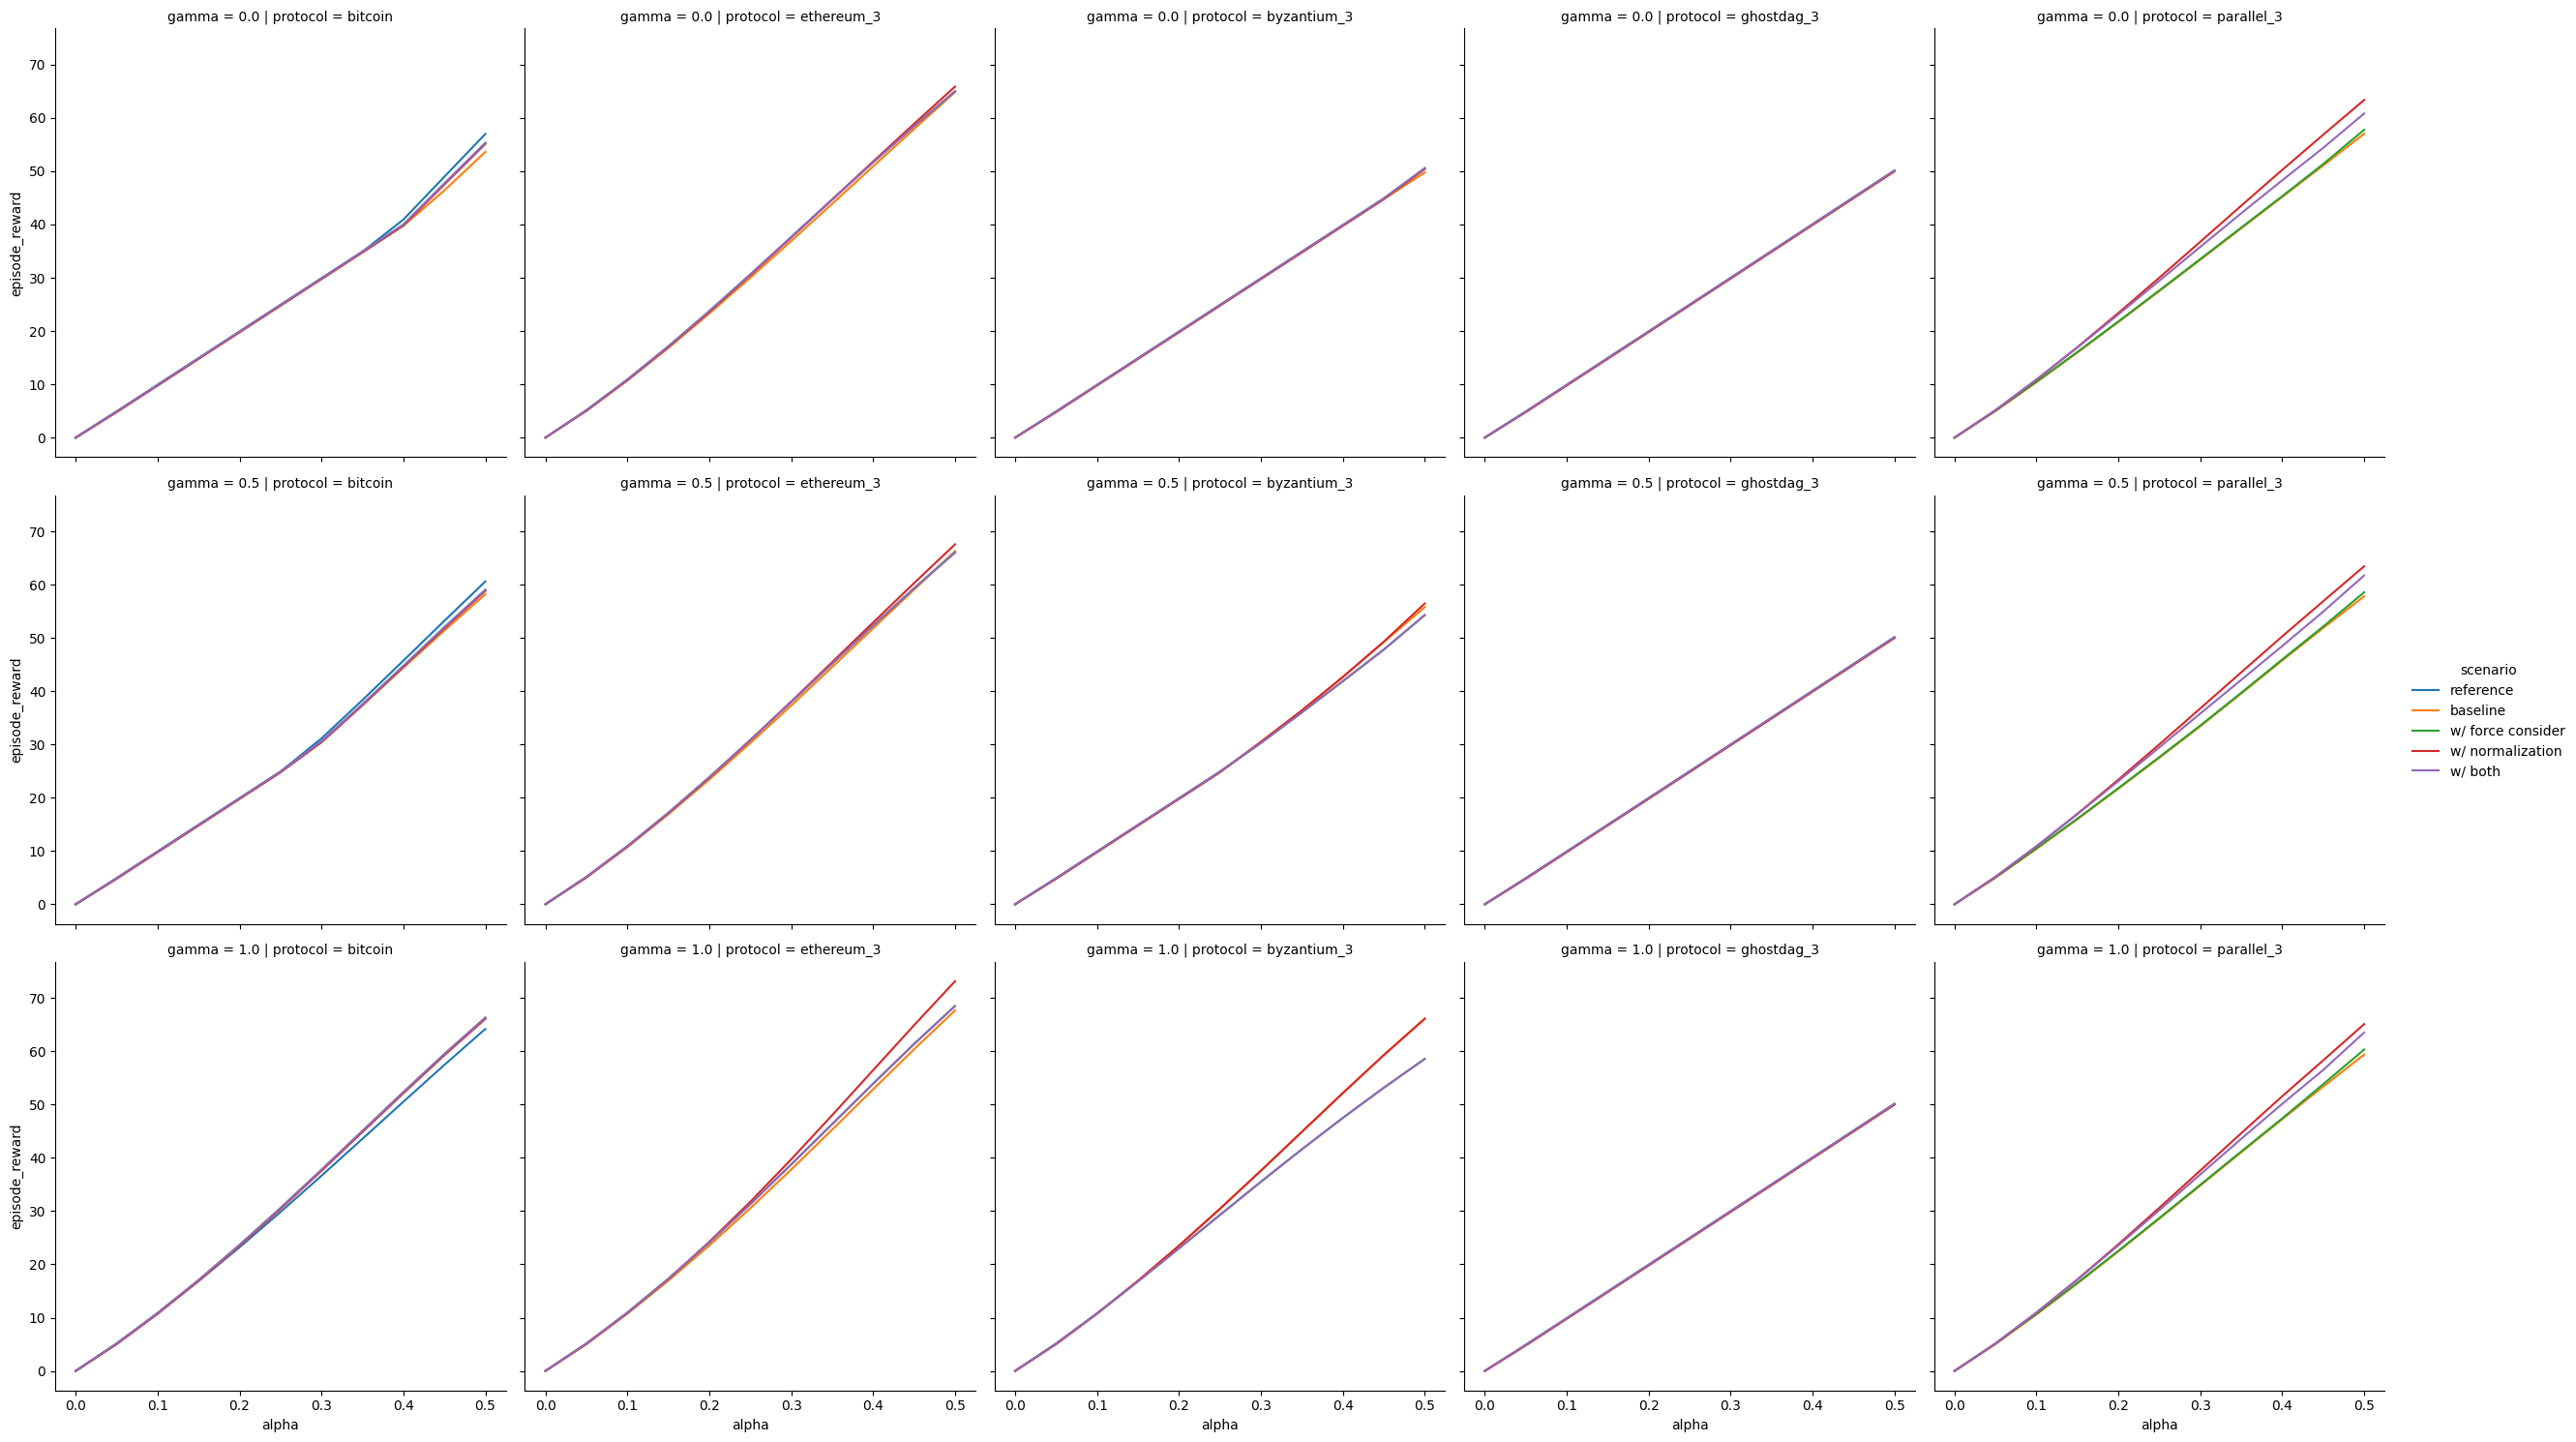

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    row="gamma",
)

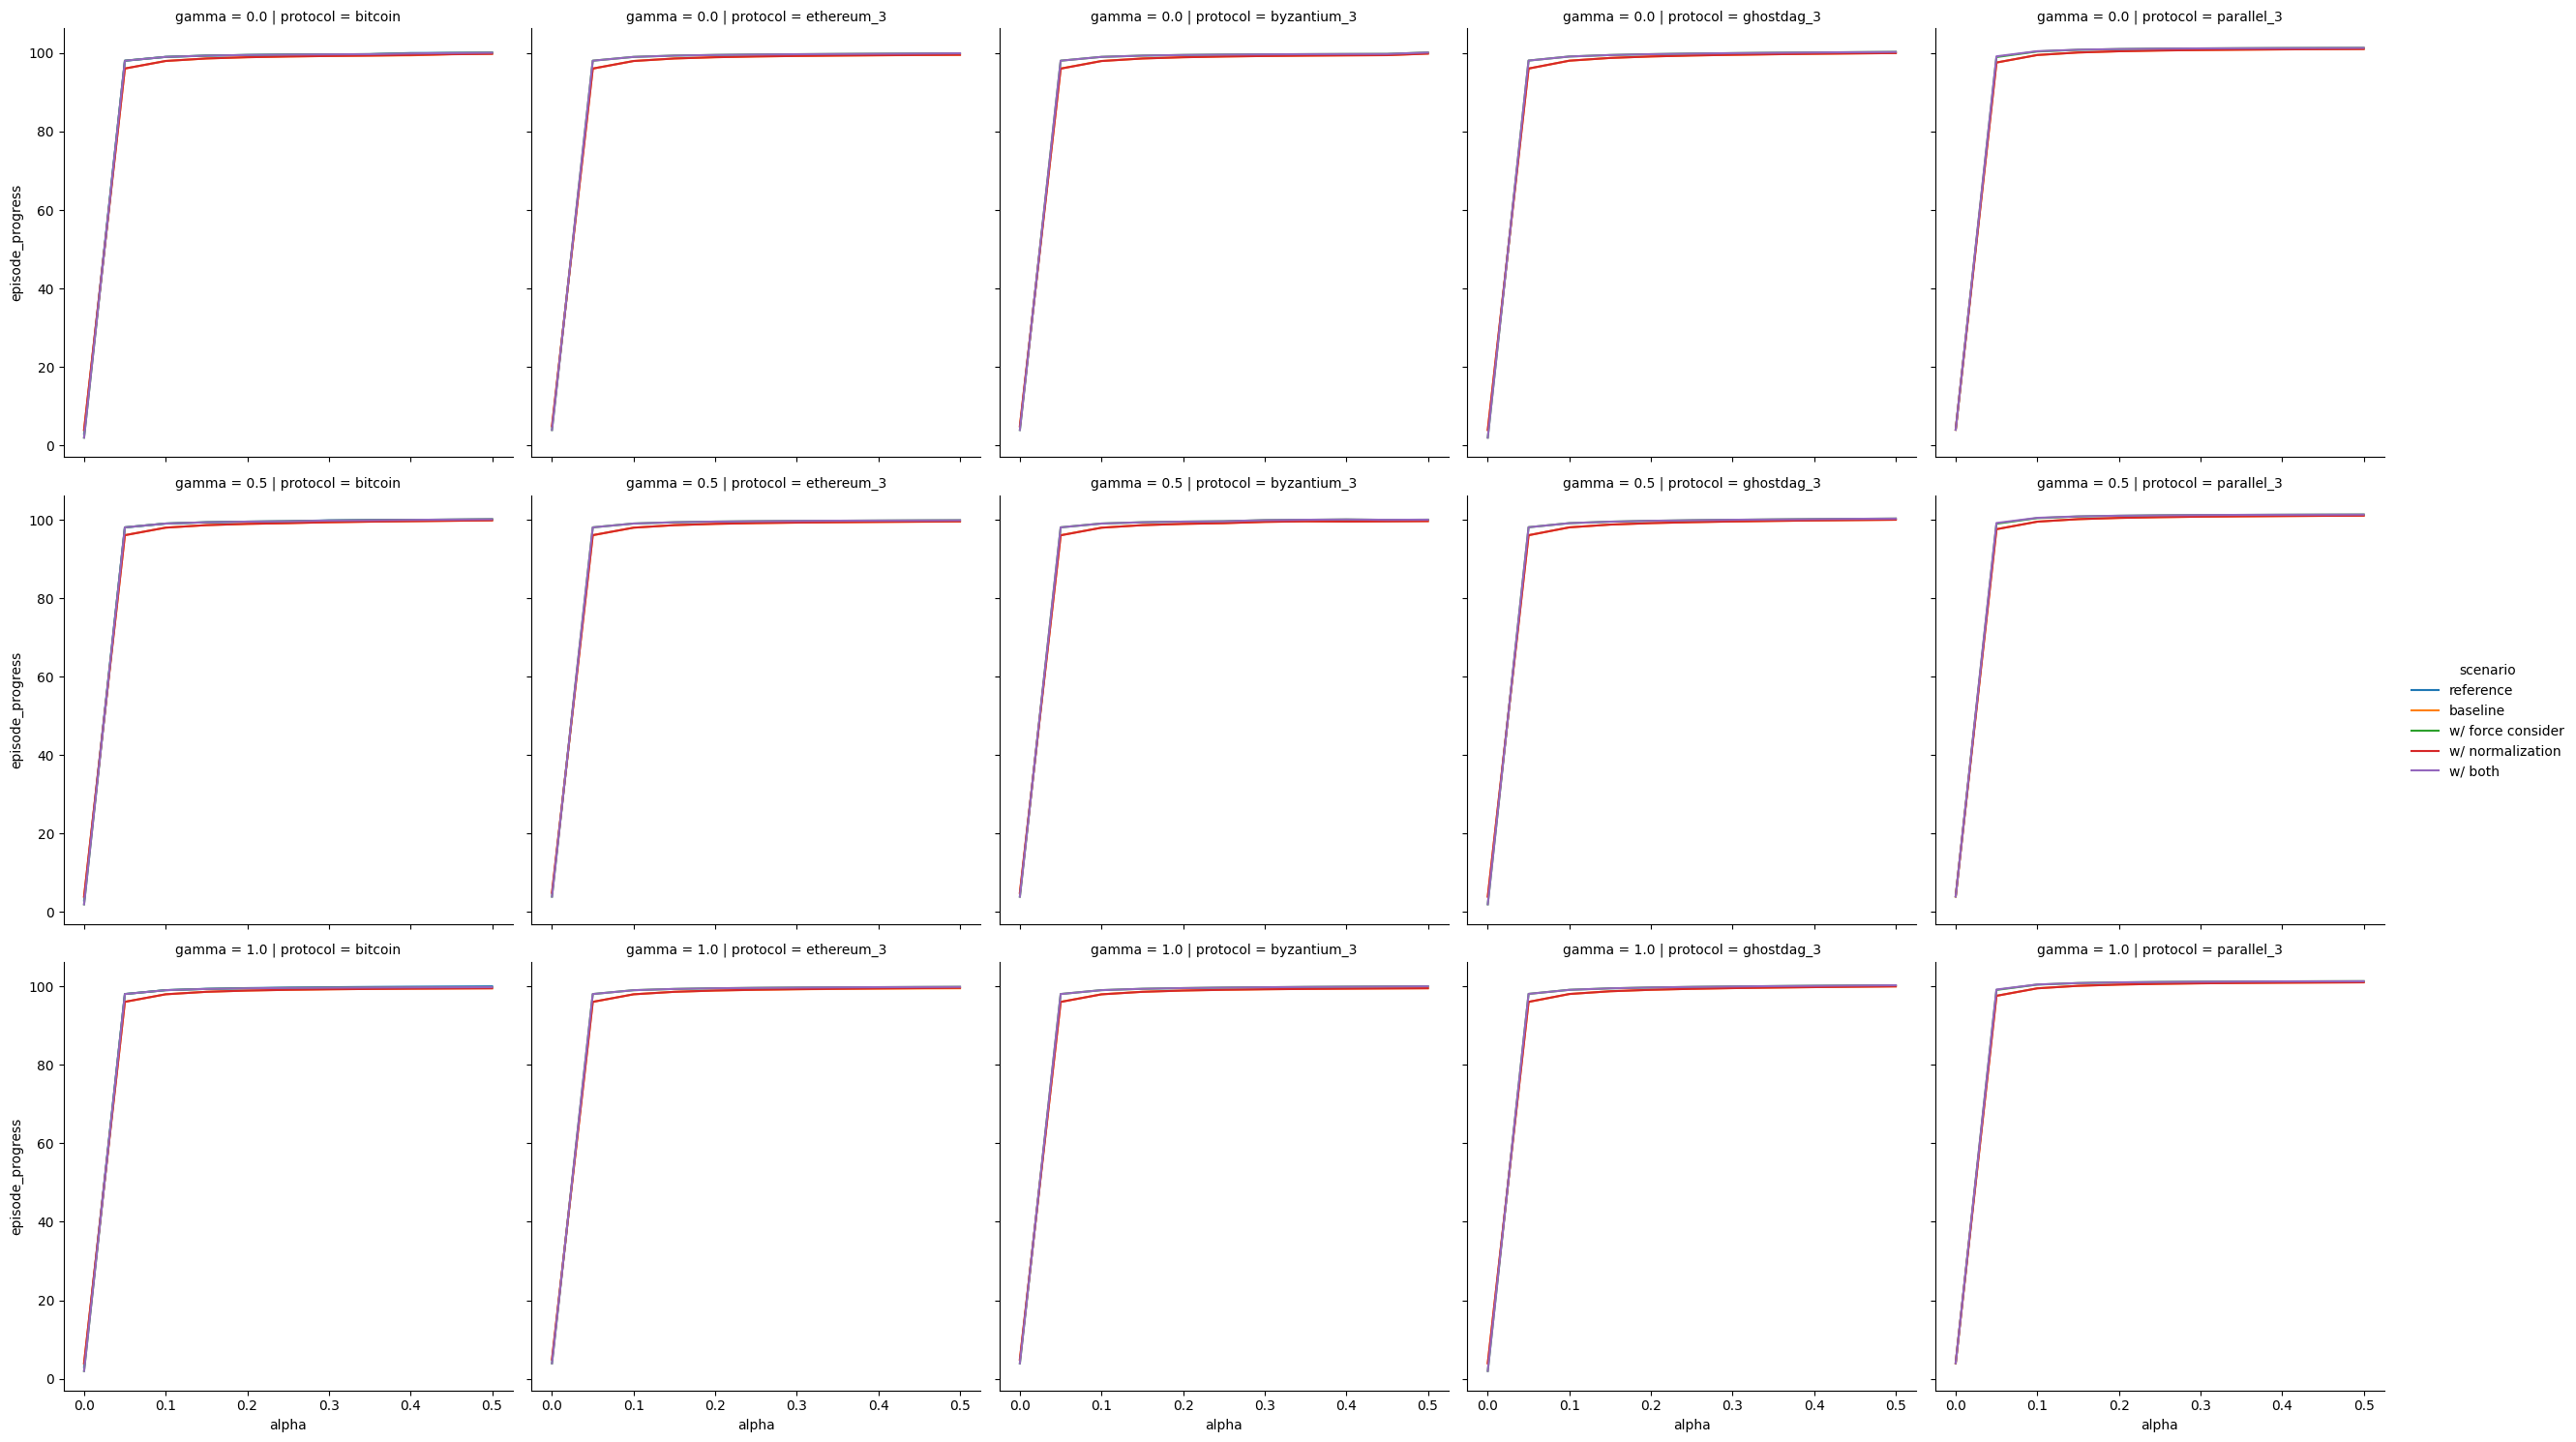

In [6]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    row="gamma",
)